# Herron Topic 5 - Simulations

In finance, we typically perform simulations with [Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method).
Monte Carlo methods are used throughout science, engineering, and mathematics, and they are especially useful in finance due to the randomness of asset prices.
This lecture notebook provides an introduction to [Monte Carlo methods in finance](https://en.wikipedia.org/wiki/Monte_Carlo_methods_in_finance).


The basic idea behind Monte Carlo methods in finance is to create many possible paths of financial variables (e.g., stock prices, interest rates, exchange rates) based on their historical behavior, statistical properties, and any other relevant factors.
We use these paths to simulate the performance of financial instruments or portfolios, and then we aggregate these results to estimate metrics of interest.
This approach helps us model and analyze complex financial problems that may be difficult or impossible to solve analytically.


We could spend a semester (or more) on simulations and Monte Carlo methods.
In this lecture notebook, we will limit our focus to:

1. Option pricing: Monte Carlo methods can be used to estimate the fair value of financial derivatives, such as options and warrants. By simulating the potential future paths of the underlying asset and calculating the payoffs of the derivative at each path, the expected payoff can be computed and discounted to present value to determine the option's price.
1. Value at Risk (VaR): Monte Carlo simulations can be used to compute VaR, a widely used risk management metric that estimates the potential loss in the value of a portfolio over a specific time horizon, given a certain level of confidence (e.g., 95% or 99%). By simulating numerous scenarios and observing the distribution of potential losses, the VaR can be calculated as the threshold below which a certain percentage of losses fall.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 2
pd.options.display.float_format = '{:.2f}'.format

In [3]:
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
session = requests_cache.CachedSession()

## Option Pricing

We can use Monte Carlo methods to value stock options.
First, we simulate several hundred or thousand possible (but random) price paths for the underlying stock.
Then, we calculate the payoff for each path.
On some paths, the option will expire "in the money" with $S_T > K$ and pay $S_T - K$.
On other paths, the option will expire "out of the money" with $S_T < K$ and pay 0.
We average these payoffs and discount them to today.
The present value of these payoffs is the option price.
This is an illustrative example, and there is a lot of depth to [Monte Carlo methods for option pricing](https://en.wikipedia.org/wiki/Monte_Carlo_methods_for_option_pricing).

### Simulating Stock Prices

We can simulate stock prices with the following stochastic differential equation (SDE) for Geometric Brownian Motion (GBM): $dS = \mu S dt + \sigma S dW_t$.
GBM does not account for mean-reversion and time-dependent volatility.
So GBM is often used for stocks and not for bond prices, which tend to display long-term reversion to the face value.
In the GBM SDE:

1. $S$ is the stock price
1. $\mu$ is the drift coefficient (i.e., instantaneous expected return)
1. $\sigma$ is the diffusion coefficient (i.e., volatility of the drift)
1. $W_t$ is the Wiener Process or Brownian Motion

The GBM SDE has a closed-form solution: $S(t) = S_0 \exp\left(\left(\mu - \frac{1}{2}\sigma^2\right)t + \sigma W_t\right)$.
We can apply this closed form solution recursively: $S(t_{i+1}) = S(t_i) \exp\left(\left(\mu - \frac{1}{2}\sigma^2\right)(t_{i+1} - t_i) + \sigma \sqrt{t_{i+1} - t_i} Z_{i+1}\right)$.
Here, $Z_i$ is a Standard Normal random variable ($dW_t$ are independent and normally distributed) and $i = 0, \ldots, T-1$ is the time index.

We can use this closed form solution to simulate stock prices for AAPL.

In [4]:
aapl = (
    yf.download(tickers='AAPL', progress=False)
    .assign(
        Date=lambda x: x.index.tz_localize(None),
        Return=lambda x: x['Adj Close'].pct_change()
    )
    .set_index('Date')
    .rename_axis(columns=['Variable'])
)

In [5]:
aapl.describe()

Variable,Open,High,Low,Close,Adj Close,Volume,Return
count,10674.00,10674.00,10674.00,10674.00,10674.00,10674.00,10673.00
mean,17.35,17.55,17.16,17.36,16.67,325931256.70,0.00
std,36.64,37.09,36.22,36.68,36.33,337395659.86,0.03
min,0.05,0.05,0.05,0.05,0.04,0.00,-0.52
25%,0.29,0.30,0.28,0.29,0.24,119995300.00,-0.01
50%,0.49,0.50,0.48,0.49,0.41,213094000.00,0.00
75%,16.90,17.10,16.72,16.94,14.73,405541500.00,0.01
max,182.63,182.94,179.12,182.01,180.68,7421640800.00,0.33


We will use returns from 2021 to predict prices in 2022.

In [6]:
train = aapl.loc['2021']
test = aapl.loc['2022']

We will use the following function to simulate price paths.
Throughout this lecture notebook, we will use one-trading-day steps (i.e., `dt=1`).

In [7]:
def simulate_gbm(S_0, mu, sigma, n_steps, dt=1, seed=42):
    '''
    Function to simulate stock prices following Geometric Brownian Motion (GBM).
    
    Parameters
    ------------
    S_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_steps : int
        Length of the forecast horizon in time increments, so T = n_steps * dt
    dt : int
        Time increment, typically one day
    seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Array (length: n_steps + 1) of simulated prices
    '''

    np.random.seed(seed)
    dW = np.random.normal(scale=np.sqrt(dt), size=n_steps)
    W = dW.cumsum()
    
    t = np.linspace(dt, n_steps * dt, n_steps)
    
    S_t = S_0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    S_t = np.insert(S_t, 0, S_0)
    
    return S_t

Now we will simulate price paths.
Here is one simulated price path:

In [8]:
simulate_gbm(
    S_0=train['Adj Close'].iloc[-1],
    mu=train['Return'].pipe(np.log1p).mean(),
    sigma=train['Return'].pipe(np.log1p).std(),
    n_steps=test.shape[0]
)

array([176.28, 177.85, 177.65, 179.67, 184.24, 183.76, 183.27, 188.1 ,
       190.6 , 189.39, 191.22, 190.03, 188.83, 189.76, 184.3 , 179.53,
       178.13, 175.49, 176.55, 174.21, 170.55, 174.73, 174.29, 174.66,
       170.95, 169.67, 170.14, 167.25, 168.43, 167.01, 166.42, 165.02,
       170.1 , 170.24, 167.6 , 169.97, 166.9 , 167.63, 162.68, 159.47,
       160.14, 162.19, 162.8 , 162.68, 162.07, 158.5 , 156.87, 155.9 ,
       158.69, 159.72, 155.5 , 156.46, 155.68, 154.18, 155.85, 158.57,
       161.09, 159.14, 158.53, 159.53, 162.18, 161.13, 160.83, 158.2 ,
       155.41, 157.58, 161.16, 161.15, 163.9 , 165.01, 163.51, 164.62,
       168.85, 168.94, 173.35, 166.49, 168.85, 169.26, 168.64, 169.06,
       164.01, 163.61, 164.71, 168.78, 167.58, 165.63, 164.49, 167.07,
       168.11, 166.89, 168.43, 168.86, 171.65, 169.93, 169.23, 168.37,
       164.69, 165.64, 166.5 , 166.69, 166.25, 162.74, 161.83, 161.13,
       159.27, 159.03, 160.22, 165.24, 165.87, 166.72, 166.7 , 161.89,
      

We will combine `simulate_gbm()` with a list comprehension and `pd.concat()` to simulate many price paths.
To simplify this combination, we will write a helper function `simulate_gbm_series()` that:

1. Returns a series
1. Helps us vary the `seed` argument


In [9]:
def simulate_gbm_series(seed, train=train, test=test):
    S_t = simulate_gbm(
        S_0=train['Adj Close'].iloc[-1],
        mu=train['Return'].pipe(np.log1p).mean(),
        sigma=train['Return'].pipe(np.log1p).std(),
        n_steps=test.shape[0],
        seed=seed
    )
    return pd.Series(data=S_t, index=test.index.insert(0, train.index[-1]))

In [10]:
n = 100

S_t = pd.concat(
    objs=[simulate_gbm_series(seed=seed) for seed in range(n)],
    axis=1,
    keys=range(n),
    names=['Simulation']
)

In [11]:
S_t

Simulation,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-31,176.28,176.28,176.28,176.28,176.28,176.28,176.28,176.28,176.28,176.28,...,176.28,176.28,176.28,176.28,176.28,176.28,176.28,176.28,176.28,176.28
2022-01-03,181.45,181.05,175.30,181.52,176.60,177.70,175.59,181.24,176.72,176.47,...,175.84,174.78,177.11,181.07,178.55,174.62,176.66,171.64,177.79,176.07
2022-01-04,182.80,179.50,175.33,182.97,178.19,176.96,177.82,180.10,179.98,175.85,...,175.39,172.06,178.16,184.44,183.09,173.20,176.71,170.66,182.64,182.08
2022-01-05,185.84,178.19,169.69,183.45,175.59,184.08,178.62,180.39,174.71,172.95,...,173.94,170.75,176.28,190.75,181.24,174.32,175.06,168.84,185.75,183.09
2022-01-06,192.75,175.38,174.33,178.31,177.72,183.54,176.28,181.74,171.11,173.10,...,171.94,170.18,169.30,192.36,186.53,176.16,176.24,171.73,183.87,187.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,264.37,309.02,209.29,243.87,280.98,228.05,238.47,208.71,217.12,253.82,...,239.90,350.58,237.84,239.82,211.79,240.60,222.35,183.09,213.59,252.19
2022-12-27,269.20,307.19,210.77,252.25,279.95,227.38,235.26,207.00,213.48,260.27,...,233.63,350.19,239.30,241.52,213.10,241.15,226.32,184.40,213.79,251.71
2022-12-28,266.04,316.44,212.71,256.82,276.97,225.13,239.62,206.86,212.20,256.62,...,237.98,348.81,243.23,238.31,212.25,233.59,236.23,186.87,211.93,249.90


Below, we prefix the simulated price path column names with `_` to hide them from the legend.
However, this feature triggers a warning *100 times*!
We will suppress these 100 warnings with the warnings package.
Generally, we should avoid suppressing warnings, however it is the easiest option here.

In [12]:
import warnings

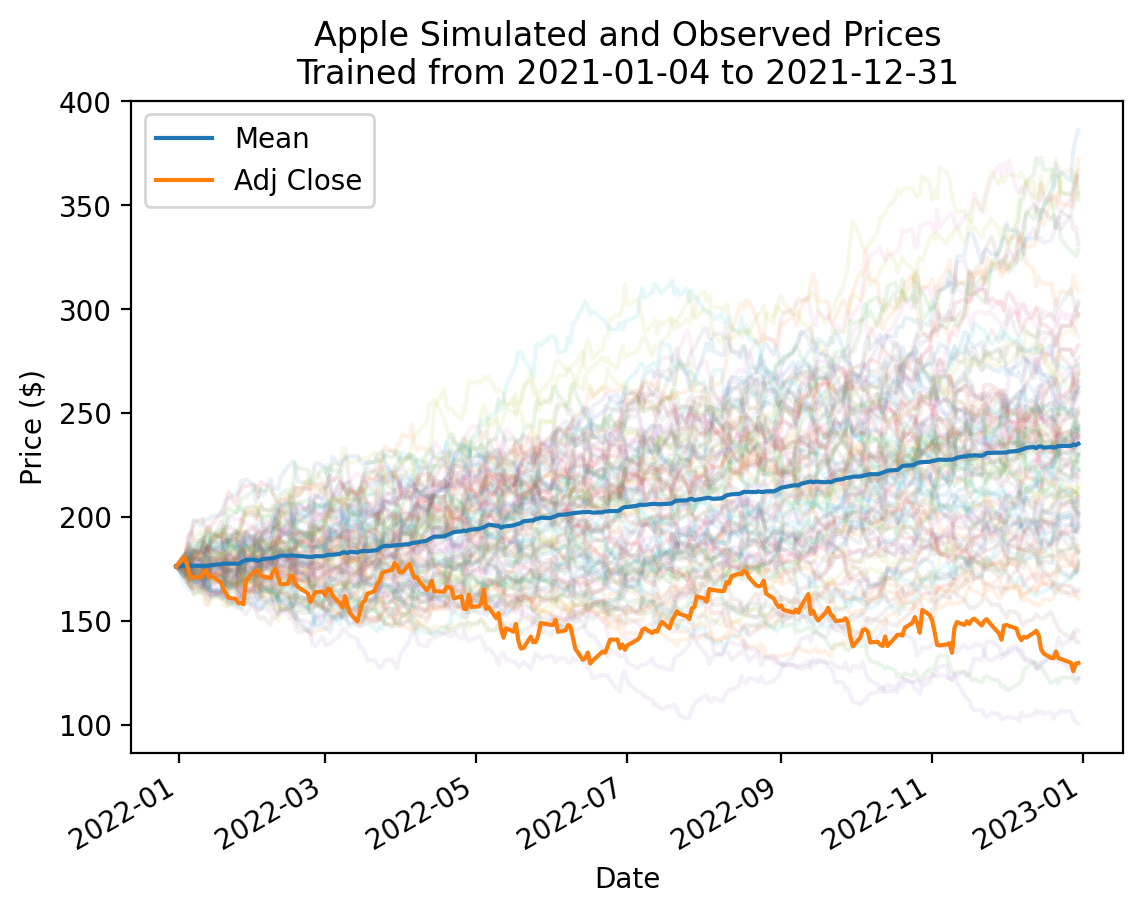

In [13]:
fig, ax = plt.subplots(1,1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    S_t.add_prefix('_').plot(alpha=0.1, ax=ax)
S_t.mean(axis=1).plot(label='Mean', ax=ax)
aapl.loc[S_t.index, ['Adj Close']].plot(label='Observed', ax=ax)
plt.legend()
plt.ylabel('Price ($)')
plt.title(
    'Apple Simulated and Observed Prices' + 
    f'\nTrained from {train.index[0]:%Y-%m-%d} to {train.index[-1]:%Y-%m-%d}'
)
plt.show()

### Pricing Options

We can use simulated price paths to price options!
We will use the Black and Scholes (1973) formula as a benchmark.
Black and Scholes (1973) provide a closed form (analytic) solution to price European options.

In [15]:
from scipy.stats import norm

In [16]:
def price_bs(S_0, K, T, r, sigma, type='call'):
    '''
    Function used for calculating the price of European options using the analytical form of the Black-Scholes model.
    
    Parameters
    ------------
    S_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to expiration in days
    r : float
        Daily risk-free rate
    sigma : float
        Standard deviation of daily stock returns
    type : str
        Type of the option. Allowable: ['call', 'put']
    
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using the Black-Scholes model
    '''
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if type == 'call':
        val = (norm.cdf(d1, 0, 1) * S_0) - (norm.cdf(d2, 0, 1) * K * np.exp(-r * T))
    elif type == 'put':
        val = (norm.cdf(-d2, 0, 1) * K * np.exp(-r * T)) - (norm.cdf(-d1, 0, 1) * S_0)
    else:
        raise ValueError('Wrong input for type!')
        
    return val

We can use the AAPL parameters above to price a European call option on AAPL stock.
We will calculate its price at the end of 2021 with an expiration at the end of 2022, assuming a 5% risk-free rate.

In [17]:
S_0 = train['Adj Close'].iloc[-1]
K = 100
T = test.shape[0]
r = 0.05/252
sigma = train['Return'].pipe(np.log1p).std()

In [19]:
S_0

176.27622985839844

In [18]:
_ = price_bs(
    S_0=S_0,
    K=K,
    T=T,
    r=r,
    sigma=sigma
)

print(f'Black and Scholes (1973) option price: {_:0.2f}')

Black and Scholes (1973) option price: 81.21


To simulate the Black and Scholes (1973) option price, we must simulate AAPL prices with the same 5% risk-free rate as the drift.
We will write a new helper function to use the same inputs as above.

In [23]:
def simulate_gbm_series(seed, S_0=S_0, T=T, r=r, sigma=sigma, train=train, test=test):
    S_t = simulate_gbm(
        S_0=S_0,
        mu=r,
        sigma=sigma,
        n_steps=T,
        seed=seed
    )
    return pd.Series(data=S_t, index=test.index.insert(0, train.index[-1]))

We will simulate more price paths to increase the precision of out option price.

In [24]:
n = 10_000

S_t = pd.concat(
    objs=[simulate_gbm_series(seed=seed) for seed in range(n)],
    axis=1,
    keys=range(n),
    names=['Simulation']
)

In [25]:
S_t

Simulation,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-31,176.28,176.28,176.28,176.28,176.28,176.28,176.28,176.28,176.28,176.28,...,176.28,176.28,176.28,176.28,176.28,176.28,176.28,176.28,176.28,176.28
2022-01-03,181.27,180.87,175.13,181.34,176.43,177.52,175.42,181.06,176.54,176.29,...,178.14,175.95,174.19,173.95,172.99,172.26,173.57,176.58,177.60,174.86
2022-01-04,182.44,179.15,174.99,182.61,177.84,176.61,177.47,179.75,179.63,175.50,...,177.45,176.81,175.57,176.18,171.43,171.36,178.19,175.19,176.40,176.52
2022-01-05,185.30,177.67,169.19,182.91,175.08,183.54,178.09,179.85,174.20,172.44,...,180.20,175.37,176.23,174.00,167.70,169.66,180.88,175.69,176.73,176.66
2022-01-06,191.99,174.70,173.65,177.61,177.02,182.82,175.59,181.03,170.43,172.42,...,183.12,176.18,175.12,176.93,167.96,172.82,182.73,176.78,172.54,175.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,207.42,242.46,164.21,191.34,220.46,178.93,187.11,163.75,170.35,199.15,...,156.18,165.90,137.42,252.22,144.24,129.41,242.87,204.14,194.58,186.51
2022-12-27,211.01,240.78,165.21,197.72,219.43,178.22,184.40,162.25,167.33,204.00,...,160.32,164.82,138.60,255.43,145.55,133.71,241.07,205.05,187.88,192.04
2022-12-28,208.33,247.79,166.57,201.11,216.88,176.29,187.63,161.99,166.16,200.95,...,158.05,164.04,139.88,259.64,146.61,131.03,240.96,213.31,191.79,192.79


We can compare this price to a simulated price.
The payoff on the call option is $S_T - K$ or $0$, whichever is higher.
The price of the option is the present value of the mean payoff, discounted at the risk-free rate.

In [26]:
payoff = np.maximum(S_t.iloc[-1] - K, 0)
_ = payoff.mean() * np.exp(-r * T)

print(f'Simulated option price: {_:0.2f}')

Simulated option price: 81.92


The option prices do not match exactly.
However, we can simulate more price paths to bring our simulated option price closer to the analytic solution.

## Estimating Value-at-Risk using Monte Carlo

Value-at-Risk (VaR) measures the risk associated with a portfolio
VaR reports the worst expected loss, at a given level of confidence, over a certain horizon under normal market conditions. 
For example, say the 1-day 95% VaR of our portfolio is \$100.
This implies that that 95% of the time (under normal market conditions), we should not lose more than \\$100 over one day.
We typically present VaR as a positive value, so a VaR of \$100 implies a loss of less than \$100.

We can calculate VaR several ways, including:

- Parametric Approach (Variance-Covariance)
- Historical Simulation Approach
- Monte Carlo simulations

We only consider the last method to calculate the 1-day VaR of an portfolio of 20 shares each of META and GOOG.

In [27]:
tickers = ['GOOG', 'META']
shares = np.array([20, 20])
T = 1
n_sims = 10_000

However, we will download all data from Yahoo! Finance and subset our data later.

In [28]:
df = (
    yf.download(tickers=tickers, progress=False)
    .assign(
        Date=lambda x: x.index.tz_localize(None),
    )
    .set_index('Date')
    .rename_axis(columns=['Variable', 'Ticker'])
)

Next, we calculate daily returns during 2022.
Choosing the window to define "normal market conditions" is part art, part science, and beyod the scope of this lecture notebook.

In [29]:
returns = df['Adj Close'].pct_change().loc['2022']

In [30]:
returns

Ticker,GOOG,META
Date,,
2022-01-03,0.00,0.01
2022-01-04,-0.00,-0.01
2022-01-05,-0.05,-0.04
2022-01-06,-0.00,0.03
2022-01-07,-0.00,-0.00
...,...,...
2022-12-23,0.02,0.01
2022-12-27,-0.02,-0.01
2022-12-28,-0.02,-0.01


We will need the variance-covariance matrix.

In [33]:
cov_mat = returns.cov()

cov_mat * 1_000_000

Ticker,GOOG,META
Ticker,,
GOOG,596.48,674.26
META,674.26,1638.50


We will use the variance-covariance matrix to calculate the Cholesky decomposition.

In [34]:
chol_mat = np.linalg.cholesky(cov_mat)

chol_mat

array([[0.02, 0.  ],
       [0.03, 0.03]])

The Cholesky decomposition helps us generate random variables with the same variance and covariance as the observed data.

In [35]:
rv = np.random.normal(size=(n_sims, len(tickers)))

In [36]:
correlated_rv = (chol_mat @ rv.T).T

In [37]:
correlated_rv

array([[ 0.04,  0.05],
       [ 0.02,  0.02],
       [-0.02, -0.04],
       ...,
       [-0.04,  0.01],
       [-0.  , -0.09],
       [-0.02,  0.  ]])

These random variables have a variance-covariance matrix similar to the real data.

In [38]:
np.cov(correlated_rv.T)  * 1_000_000

array([[ 597.18,  685.37],
       [ 685.37, 1647.31]])

In [41]:
np.allclose(cov_mat, np.cov(correlated_rv.T), rtol=0.05)

True

In [50]:
np.mean(correlated_rv, axis=0) * 100

array([0.02, 0.02])

In [49]:
returns.mean().values * 100

array([-0.16, -0.32])

Here are the parameters for the simulated price paths:

In [51]:
mu = returns.mean().values
sigma = returns.std().values
S_0 = df.loc['2021', 'Adj Close'].iloc[-1].values
P_0 = S_0.dot(shares)

Calculate terminal prices using the GBM formula above:

In [52]:
S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * correlated_rv)

S_T

array([[144.79, 336.82],
       [144.74, 336.38],
       [144.61, 335.63],
       ...,
       [144.53, 336.3 ],
       [144.65, 334.95],
       [144.6 , 336.2 ]])

Calculate terminal portfolio values and returns.
Note that these are dollar values, since VaR is typically expressed in dollar values.

In [53]:
P_T = S_T.dot(shares)

P_T

array([9632.23, 9622.51, 9604.65, ..., 9616.48, 9592.05, 9615.98])

In [54]:
P_diff = P_T - P_0

P_diff

array([ 11.64,   1.92, -15.94, ...,  -4.11, -28.54,  -4.61])

In [55]:
P_diff.mean()

-4.376750155672959

Next, we calculate VaR.

In [56]:
percentiles = [0.01, 0.05, 0.1]
var = np.percentile(P_diff, percentiles)

for x, y in zip(percentiles, var):
    print(f'1-day VaR with {100-x}% confidence: ${-y:.2f}')

1-day VaR with 99.99% confidence: $48.02
1-day VaR with 99.95% confidence: $44.65
1-day VaR with 99.9% confidence: $42.63


Finally, we will plot VaR:

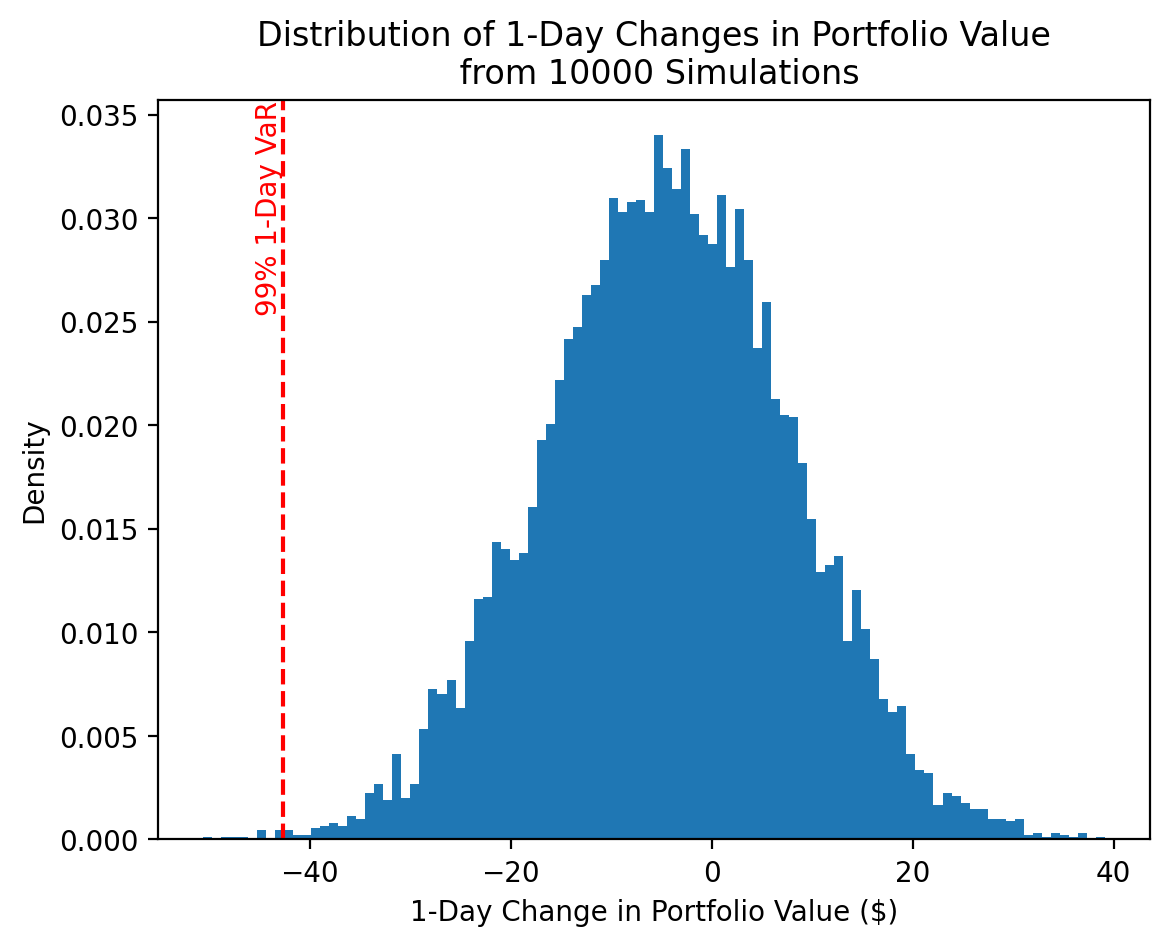

In [57]:
fig, ax = plt.subplots()
ax.hist(P_diff, bins=100, density=True)
ax.set_title(f'Distribution of 1-Day Changes in Portfolio Value\n from {n_sims} Simulations')
ax.axvline(x=var[2], color='red', ls='--')
ax.text(x=var[2], y=1, s='99% 1-Day VaR', color='red', ha='right', va='top', rotation=90, transform=ax.get_xaxis_transform())
ax.set_ylabel('Density')
ax.set_xlabel('1-Day Change in Portfolio Value ($)')
plt.show()